In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt

import sklearn.preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# we will substract 3000 rows on beginning
data = pd.read_csv("atp.csv")
Y = pd.DataFrame(data['target'][3000:]).reset_index(drop=True)
X = data.drop(['target'], axis = 1)[3000:].reset_index(drop=True)

In [3]:
X

,wins_game_semester_level1_0,wins_game_semester_level2_0,wins_game_semester_level3_0,wins_game_year_level1_0,wins_game_year_level2_0,wins_game_year_level3_0,wins_game_career_level1_0,wins_game_career_level2_0,wins_game_career_level3_0,losses_game_semester_level1_0,...,percent_career_Grass_1,percent_hth_wins_year_1,percent_hth_wins_career_1,percent_tournament.1,surface,best_of,match_rank,year,sin_day,cos_day
0,0,24,86,0,36,192,27,96,436,0,...,0.500000,0.0,0.000000,1.000000,0.0,3,0.25000,1994,0.171293,0.985220
1,18,110,135,32,176,257,65,334,647,17,...,0.000000,0.0,0.000000,1.000000,0.0,3,0.25000,1994,0.171293,0.985220
2,0,22,50,6,81,149,77,333,564,0,...,0.647059,0.0,0.333333,1.000000,0.0,3,0.25000,1994,0.171293,0.985220
3,0,0,27,0,0,67,0,41,133,0,...,0.142857,0.0,0.000000,0.600000,0.0,5,0.00225,1994,0.288482,0.957485
4,26,64,108,78,191,268,133,381,673,5,...,0.000000,0.0,0.333333,0.333333,0.0,3,0.02250,1994,0.508671,0.860961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48706,0,49,171,0,63,242,12,214,757,9,...,0.451613,0.0,0.500000,0.666667,0.0,3,0.09000,2021,-0.790946,0.611886
48707,0,0,140,0,0,148,836,1845,2709,0,...,0.000000,0.0,0.000000,1.000000,0.0,3,0.09000,2021,-0.790946,0.611886
48708,0,96,176,12,137,270,18,298,663,32,...,0.450000,0.0,0.250000,0.833333,0.0,3,0.15000,2021,-0.790946,0.611886
48709,0,43,140,0,43,180,0,67,410,0,...,0.500000,0.0,1.000000,1.000000,0.0,3,0.15000,2021,-0.790946,0.611886


## naive classifier using ranking points

In [4]:
def naive_classifier(column, data, Y):
    acc = 0
    for ind in data.index:
        r0 = data.at[ind, f'{column}_0']
        r1 = data.at[ind, f'{column}_1']
        if r0 > r1 and Y.at[ind, 'target'] == 0:
            acc += 1
        if r0 < r1 and Y.at[ind, 'target'] == 1:
            acc += 1
    return acc/len(data)

In [5]:
print("accuracy: ", naive_classifier('rank_points', X, Y))

accuracy:  0.6618217651043912


## naive classifier using elo points

In [6]:
print("accuracy: ", naive_classifier('elo', X, Y))

accuracy:  0.6839112315493421


## so far our best results are: elo: 0.684 , rank: 0.662

## dealing with nulls (after update we do not have any nulls)

In [7]:
# we replace Nans with random gaussian data
def generate_data_on_Nan(column, data):
    m = data[column].mean()
    std = data[column].std()
    #print(m, std)
    for ind in data.index:
        if np.isnan(data.at[ind, column]):
            data.at[ind, column] = np.random.normal(m, std)

In [8]:
# check where are Nans, and how many
for c in X.columns:
    if X[c].isna().sum() > 0:
        print(c, X[c].isna().sum())

In [9]:
# check where are Nans and replace them with gaussian random
for c in X.columns:
    if X[c].isna().sum() > 0:
            generate_data_on_Nan(c, X)

### Features importance

In [10]:
corr_with_target = []
for cname in data.columns:
    #print(f"{cname.ljust(25)}:\t {data['target'].corr(data[cname]).round(decimals=3)}")
    corr_with_target.append((abs(data['target'].corr(data[cname])), cname))

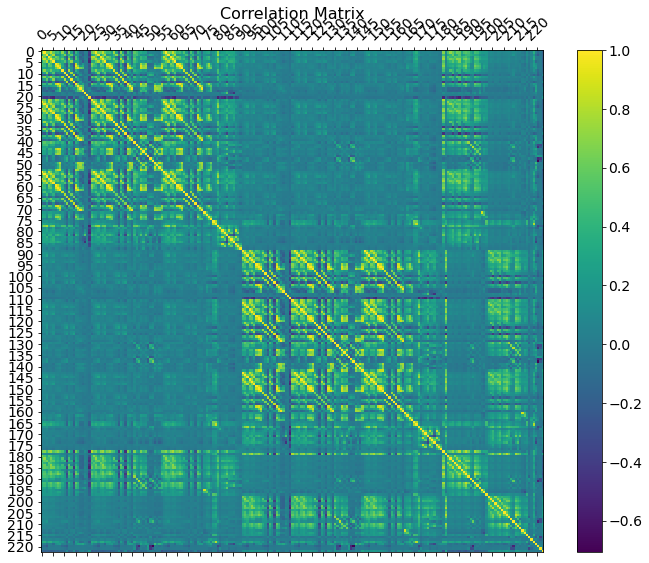

In [11]:
f = plt.figure(figsize=(12,9))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(0, data.columns.shape[0], 5), range(0, data.columns.shape[0], 5), fontsize=14, rotation=45)
plt.yticks(range(0, data.columns.shape[0], 5), range(0, data.columns.shape[0], 5), fontsize=14)
cb = plt.colorbar()
plt.title('Correlation Matrix', fontsize=16)

In [12]:
#for corr in sorted(corr_with_target)[:-50:-1]:
#    print(f"{corr[1].ljust(25)}:\t {corr[0].round(decimals=3)}")

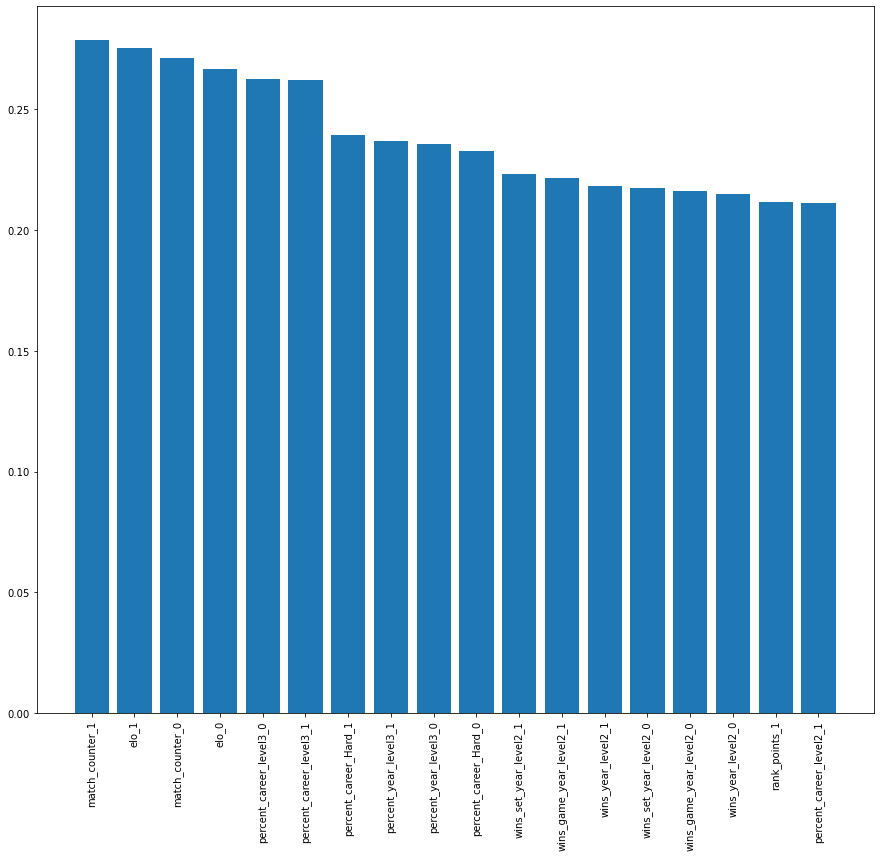

In [13]:
plt.figure(figsize=(15,13))
plt.bar([x[1] for x in sorted(corr_with_target)[-2:-20:-1]],
        [x[0] for x in sorted(corr_with_target)[-2:-20:-1]]
       )
plt.xticks(rotation=90)
plt.show()

### PCA

In [14]:
X_std = pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(X), columns = X.columns)
y = np.asarray(Y).ravel()
xx = np.random.choice(X_std.shape[0], 500)
new_x = X_std.iloc[xx]
new_y = Y.iloc[xx].reset_index(drop=True)
pca_x = PCA(n_components=2)
X_comp = pca_x.fit_transform(new_x)
princ_comp_X = pd.DataFrame(X_comp, columns=['0','1'])

In [15]:
print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))

Explained variation per principal component: [0.17862784 0.11866211]


<Figure size 432x288 with 0 Axes>

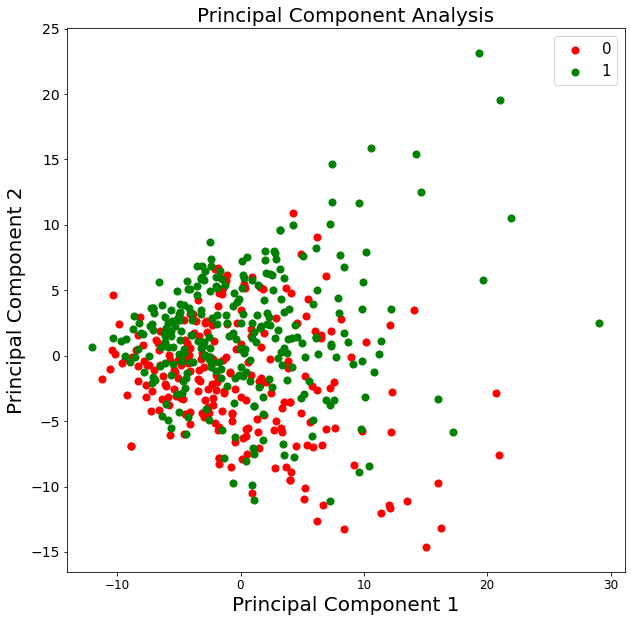

In [16]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indices = new_y['target'] == target
    plt.scatter(princ_comp_X.loc[indices, '0']
               , princ_comp_X.loc[indices, '1'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

In [17]:
model = XGBClassifier(use_label_encoder=False).fit(X_std,y, eval_metric='rmse')
importances = model.feature_importances_

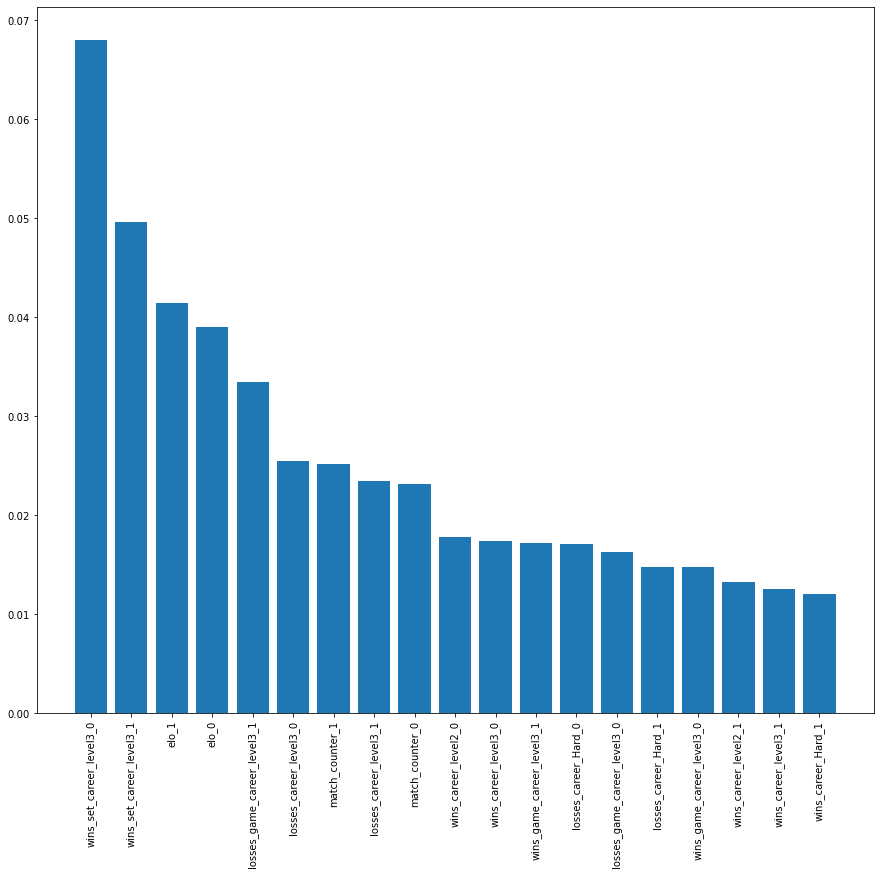

In [18]:
importance = []
for i in range(len(importances)):
    importance.append((importances[i], X_std.columns[i]))
plt.figure(figsize=(15,13))
plt.bar([x[1] for x in sorted(importance)[:-20:-1]],
        [x[0] for x in sorted(importance)[:-20:-1]]
       )
plt.xticks(rotation=90)
plt.show()

In [19]:
def win_to_feature(data, column, target, freq=20):
    x_max = max(data[column])
    x_min = min(data[column])
    column_groups = np.linspace(x_min,x_max,num=freq)
    win_ratio = [data.loc[(data[column]>=column_groups[i]) & (Y['target']==target)
                               & (data[column]<column_groups[i+1]) ].shape[0] /
                               data.loc[ (data[column]>= column_groups[i])
                                           & (data[column]< column_groups[i+1])].shape[0] for i in range(0,freq-1)]
    plt.figure(figsize=(10,7))
    plt.plot(column_groups[0:freq - 1],win_ratio)
    plt.ylabel('win_ratio')
    plt.xlabel(column)
    plt.show()

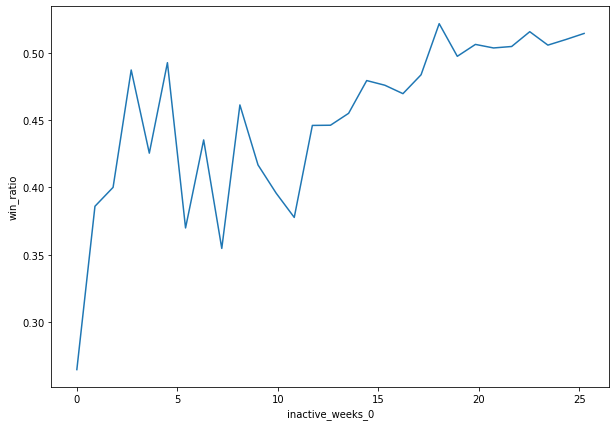

In [20]:
win_to_feature(X, "inactive_weeks_0", 0, freq=30)

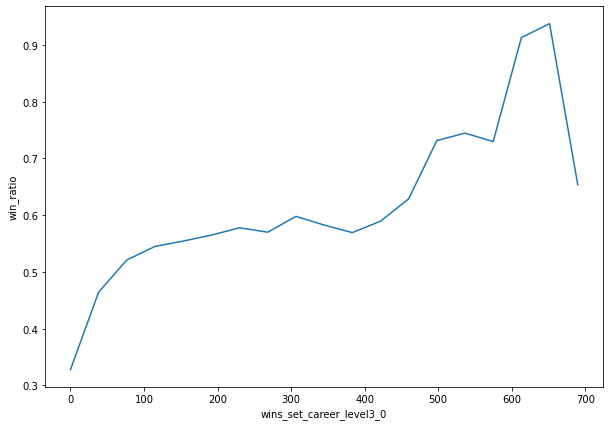

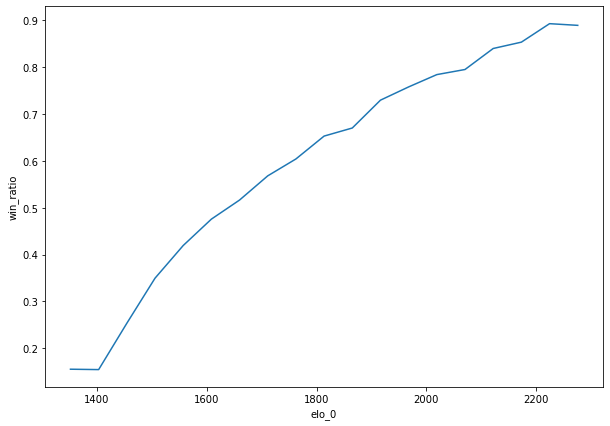

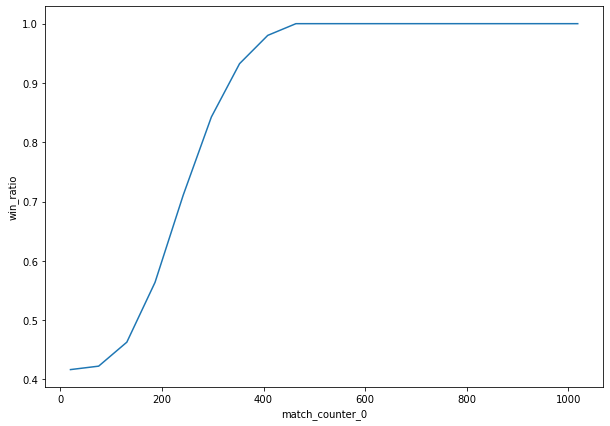

In [21]:
win_to_feature(X, "wins_set_career_level3_0", 0)
win_to_feature(X, "elo_0", 0)
win_to_feature(X, "match_counter_0", 0)

## scalers

In [15]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
standard_scaler = sklearn.preprocessing.StandardScaler()
X_mx = pd.DataFrame(min_max_scaler.fit_transform(X), columns = X.columns)
X_std = pd.DataFrame(standard_scaler.fit_transform(X), columns = X.columns)

In [27]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=15000, n_splits=4, test_size=5000)
y = np.asarray(Y).ravel()
pca = PCA()
scaler = sklearn.preprocessing.StandardScaler()
classifier = RidgeClassifier(fit_intercept=False, )
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("classifier", classifier)])
#param_grid = {
#    "pca__n_components": [5, 15, 30, 45, 60, 90, 120, 148],
#    #"logistic__C": np.logspace(-4, 4, 4),
#}
param_grid = {
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 10.0, 100.0, 1000.0, 10000.0]
}
search = GridSearchCV(classifier, param_grid, n_jobs=-1, verbose=3, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
Best parameter (CV score=0.796):
{'alpha': 100.0}


In [28]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.793700 (0.020293) with: {'alpha': 0.1}
0.793800 (0.020427) with: {'alpha': 0.2}
0.793850 (0.020529) with: {'alpha': 0.3}
0.793850 (0.020662) with: {'alpha': 0.4}
0.793850 (0.020527) with: {'alpha': 0.5}
0.794000 (0.020635) with: {'alpha': 0.6}
0.794050 (0.020654) with: {'alpha': 0.7}
0.794000 (0.020585) with: {'alpha': 0.8}
0.794050 (0.020654) with: {'alpha': 0.9}
0.794100 (0.020766) with: {'alpha': 1.0}
0.794600 (0.021361) with: {'alpha': 10.0}
0.796100 (0.021576) with: {'alpha': 100.0}
0.787050 (0.018053) with: {'alpha': 1000.0}
0.732250 (0.006960) with: {'alpha': 10000.0}


In [29]:
classifier = LogisticRegression()
param_grid = {
    'C' : [100, 10, 1.0, 0.1, 0.01]
}
search = GridSearchCV(classifier, param_grid, n_jobs=-1, verbose=3, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameter (CV score=0.793):
{'C': 0.01}


/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
classifier = RandomForestClassifier()
param_grid = {
    'max_features' : [10,20,50,80,100]
}
search = GridSearchCV(classifier, param_grid, n_jobs=-1, verbose=3, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameter (CV score=0.866):
{'max_features': 100}


In [31]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.773450 (0.008772) with: {'max_features': 10}
0.813650 (0.009951) with: {'max_features': 20}
0.852450 (0.020889) with: {'max_features': 50}
0.860750 (0.019926) with: {'max_features': 80}
0.866100 (0.020239) with: {'max_features': 100}


In [272]:
clf = SVC(probability=True, verbose=True).fit(X_std[16000:26000], y[16000:26000])
predictions = clf.predict(X_std[26000:29000])
acc_svc= accuracy_score(y[26000:29000], predictions)
print("accuracy generate svc: ", acc_svc)

[LibSVM]accuracy generate svc:  0.6916666666666667


In [263]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=15000, n_splits=4, test_size=5000)
y = np.asarray(Y).ravel()
pca = PCA()
scaler = sklearn.preprocessing.StandardScaler()
classifier = KNeighborsClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [20],
    "classifier__n_neighbors": range(30,40,2),
    #"classifier__n_neighbors": [1,5,10,15],
    #"classifier__n_neighbors": [1,5,10,15],
    #"logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=2, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameter (CV score=0.676):
{'classifier__n_neighbors': 36, 'pca__n_components': 20}


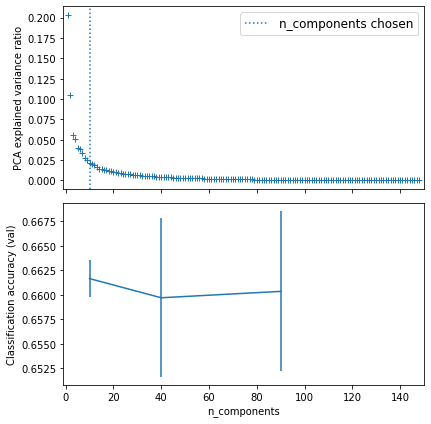

In [261]:
# Plot the PCA spectrum
pca.fit(new_x)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 150)

plt.tight_layout()
plt.show()

In [200]:
clf = LogisticRegression(max_iter=1000).fit(X_std[-10000:-500], y[-10000:-500])
predictions = clf.predict(X_std[-500:])
acc_lr = accuracy_score(y[-500:], predictions)
print("accuracy logistic reg: ", acc_lr)

accuracy logistic reg:  0.658


# Results on ML classifiers

#### we will use standard normalization with generating data instead of nulls

In [12]:
def get_test_train(X,Y):
    X_train = X.iloc[:-1000,:]
    X_train = X_train.iloc[3000:len(X_train)]
    Y_train = Y.iloc[:-1000,:]
    Y_train = Y_train.iloc[3000:len(Y_train)]
    X_test = X.iloc[-1000:,:]
    Y_test = Y.iloc[-1000:,]
    return X_train,np.asarray(Y_train).ravel(),X_test,np.asarray(Y_test).ravel()

In [13]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=15000, n_splits=4, test_size=5000)
y = np.asarray(Y).ravel()

In [183]:
#acc_sum = []
for train_index, test_index in ts_cv.split(X_std.iloc[:-10000]):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_std.iloc[train_index], X_std.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #clf = RandomForestClassifier().fit(X_train,y_train)
    #predictions = clf.predict(X_test)
    #acc_rfc = accuracy_score(y_test, predictions)
    #print("accuracy Random Forest: ", acc_rfc)
    #acc_sum += [acc_rfc]
    #all_splits = list(ts_cv.split(X, Y))

TRAIN: [ 8702  8703  8704 ... 23699 23700 23701] TEST: [23702 23703 23704 ... 28699 28700 28701]
TRAIN: [13702 13703 13704 ... 28699 28700 28701] TEST: [28702 28703 28704 ... 33699 33700 33701]
TRAIN: [18702 18703 18704 ... 33699 33700 33701] TEST: [33702 33703 33704 ... 38699 38700 38701]
TRAIN: [23702 23703 23704 ... 38699 38700 38701] TEST: [38702 38703 38704 ... 43699 43700 43701]


In [35]:
clf = RandomForestClassifier(max_features=100)
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv, n_jobs=-1, verbose=3)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[0.8678 0.884  0.8748 0.8338]
accuracy 0.87 with a standard deviation of 0.02


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.1min finished


In [16]:
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.689  0.6962 0.6882 0.6852]
accuracy 0.69 with a standard deviation of 0.00


In [36]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.784  0.8296 0.7784 0.756 ]
accuracy 0.79 with a standard deviation of 0.03


In [18]:
clf = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.671  0.6676 0.657  0.6548]
accuracy 0.66 with a standard deviation of 0.01


In [37]:
clf = RidgeClassifier()
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.8032 0.8224 0.7836 0.7662]
accuracy 0.79 with a standard deviation of 0.02


In [38]:
clf = GaussianNB()
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.6764 0.689  0.7016 0.7028]
accuracy 0.69 with a standard deviation of 0.01


In [21]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.5832 0.5868 0.579  0.5672]
accuracy 0.58 with a standard deviation of 0.01


In [39]:
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X_std[:-10000], y[:-10000], cv=ts_cv)
print(scores)
print(f'accuracy {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

[0.6354 0.6602 0.673  0.6808]
accuracy 0.66 with a standard deviation of 0.02


In [23]:
X_train,Y_train,X_test,Y_test = get_test_train(X_std[:-15000], Y[:-15000])

In [ ]:
clf = SVC(probability=True, verbose=True).fit(X_train,Y_train)
predictions = clf.predict(X_test)
acc_svc= accuracy_score(Y_test, predictions)
print("accuracy generate svc: ", acc_svc)

In [24]:
meta = LogisticRegression(max_iter=1000)
base_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'rf': RandomForestClassifier(), 
    'rc': RidgeClassifier(),
    #'gnb': GaussianNB(),
    #'xgb': XGBClassifier(use_label_encoder=False, eval_metric='rmse')
}

In [26]:
def fold_scoring(df_fold, meta_model, base_dict):
    '''
    Cycle through a dictionary of base models, fitting them then making predictions. The predictions are also 
    used as inputs for the meta model. All model predictions on the validation set are scored according to 
    MAE & RMSE. The output is two DataFrames containing the all-model scores.
    
    df_fold: DataFrame containing the sub-sample fold of interest, with the target variable in the last column
    
    meta_model: Meta model
    
    base_dict: Dictionary of base models
    '''    
    
    # Empty scorer DataFrames
    df_mae = pd.DataFrame(columns=base_dict.keys()) # Columns of DF will accord with base_dict keys
    df_rmse = pd.DataFrame(columns=base_dict.keys())
    
    # Empty dictionaries to hold the base model predictions for the meta model
    meta_dict1 = {}
    meta_dict2 = {}
    
    # Split the data length into 2/3 base-training data and 1/3 meta-training data
    n_valid = round(len(df_fold) * 0.1)
    length = len(df_fold) - n_valid # n_valid is given as per above
    n_meta = round(length/3)
    n_base = n_meta * 2
    
    X_base = df_fold.iloc[:n_base,:]
    X_meta = df_fold.iloc[n_base:(n_base + n_meta),:]
    X_valid = df_fold.iloc[length:(length + n_valid),:]
    
    # Extract target variables from each sub-sample
    y_meta = X_meta.pop('target')
    y_base = X_base.pop('target')
    y_valid = X_valid.pop('target')
    
    # Scaling the sub-samples
    X_bsc = scaler.fit_transform(X_base)
    X_msc = scaler.transform(X_meta)
    X_vsc = scaler.transform(X_valid)
    
    # Fit the base models to the base-training set, and generate predictions
    for key, reg in base_dict.items():
        reg.fit(X_bsc, y_base)
        
        z_meta = reg.predict(X_msc).tolist() # Generate predictions on meta-training set
        meta_dict1[key] = z_meta # Append predictions to dictionary
        
        z_valid = reg.predict(X_vsc).tolist() # Generate predictions on validation set for meta model
        meta_dict2[key] = z_valid

        df_mae[key] = pd.Series(round(accuracy_score(z_valid, y_valid), 4)) # Generate MAE scores for base models
        df_rmse[key] = pd.Series(round(mean_squared_error(z_valid, y_valid, squared=False), 4)) # Generate RMSE scores
    
    # Transform dictionary of predictions for meta model into DataFrames        
    df_meta1 = pd.DataFrame.from_dict(meta_dict1)
    df_meta2 = pd.DataFrame.from_dict(meta_dict2)
    
    # Train meta model using base models' predictions of meta-training set
    meta_model.fit(df_meta1, y_meta)
    
    # Generate meta model predictions of validation set
    meta_y = meta_model.predict(df_meta2)            
    
    # Obtain scores from meta model, and insert into respective scorer DataFrames
    df_mae['Stack Model'] = round(accuracy_score(meta_y, y_valid), 4)
    df_rmse['Stack Model'] = round(mean_squared_error(meta_y, y_valid, squared=False), 4)

    return df_mae, df_rmse

In [27]:
y_df = pd.DataFrame(y[:-10000], columns=['target'])
x_df = pd.DataFrame(X[:-10000])
df = pd.concat([x_df,y_df], axis=1)
df

,age_0,ht_0,hand_0,rank_0,rank_points_0,wins_semester_level1_0,wins_semester_level2_0,wins_semester_level3_0,wins_year_level1_0,wins_year_level2_0,...,percent_svpt_semester.1,percent_svpt_year.1,percent_svpt_career.1,percent_rtpt_semester.1,percent_rtpt_year.1,percent_rtpt_career.1,percent_insv_semester.1,percent_insv_year.1,percent_insv_career.1,target
0,27.835729,185.000000,1,38.0,945.0,0,2,4,1,5,...,0.604945,0.605518,0.608977,0.368810,0.378737,0.383955,0.551099,0.556944,0.558508,1
1,26.294319,180.000000,1,100.0,410.0,0,0,1,0,1,...,0.538776,0.596827,0.596827,0.415385,0.393627,0.393627,0.632653,0.608959,0.608959,1
2,28.878850,175.000000,1,32.0,1040.0,0,3,8,0,7,...,0.616769,0.613899,0.613899,0.423225,0.409100,0.409100,0.555187,0.557091,0.557091,1
3,27.444216,183.000000,1,102.0,404.0,0,0,3,0,0,...,0.648733,0.764491,0.637702,0.394986,0.449794,0.187874,0.560249,0.606371,0.502812,1
4,19.871321,180.000000,1,7.0,2560.0,1,3,7,3,10,...,0.656753,0.649838,0.650580,0.409471,0.409662,0.412491,0.502682,0.532644,0.529356,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43697,32.087611,188.000000,0,65.0,793.0,0,2,11,0,2,...,0.664946,0.658660,0.635552,0.310843,0.308476,0.319716,0.648053,0.633059,0.622238,0
43698,31.392197,193.000000,1,123.0,458.0,0,0,2,0,0,...,0.640446,0.636150,0.625838,0.412428,0.407178,0.397877,0.572927,0.576562,0.577712,1
43699,29.412731,188.000000,0,61.0,827.0,0,3,7,0,4,...,0.642405,0.646366,0.627097,0.389839,0.370657,0.362650,0.544304,0.550122,0.549119,1
43700,20.969199,186.942979,1,266.0,198.0,0,0,0,0,0,...,0.609902,0.612063,0.612176,0.408441,0.399404,0.379842,0.604635,0.610387,0.617035,1


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler = sklearn.preprocessing.StandardScaler()
mae_1st, rmse_1st = fold_scoring(df, meta, base_dict)

In [29]:
mae_1st

,lr,rf,rc,Stack Model
0,0.6815,0.6801,0.6819,0.6822


In [30]:
meta = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
mae_2nd, rmse_2nd = fold_scoring(df, meta, base_dict)

In [31]:
mae_2nd

,lr,rf,rc,Stack Model
0,0.6815,0.6838,0.6819,0.6822


In [32]:
meta = RandomForestClassifier()
mae_3rd, rmse_3rd = fold_scoring(df, meta, base_dict)

In [33]:
mae_3rd

,lr,rf,rc,Stack Model
0,0.6815,0.6796,0.6819,0.6817


In [34]:
y_df = pd.DataFrame(y[15000:-25000], columns=['target'])
x_df = pd.DataFrame(X.iloc[15000:-25000]).reset_index(drop=True)
df = pd.concat([x_df,y_df], axis=1)
df

,age_0,ht_0,hand_0,rank_0,rank_points_0,wins_semester_level1_0,wins_semester_level2_0,wins_semester_level3_0,wins_year_level1_0,wins_year_level2_0,...,percent_svpt_semester.1,percent_svpt_year.1,percent_svpt_career.1,percent_rtpt_semester.1,percent_rtpt_year.1,percent_rtpt_career.1,percent_insv_semester.1,percent_insv_year.1,percent_insv_career.1,target
0,26.817248,190.0,1,80.0,500.0,0,0,6,0,1,...,0.622969,0.613854,0.605142,0.382874,0.365462,0.365970,0.575298,0.574429,0.555065,1
1,24.911704,178.0,1,6.0,2360.0,0,3,10,2,11,...,0.632035,0.645211,0.548680,0.391400,0.394655,0.324367,0.581169,0.582396,0.701483,0
2,25.281314,168.0,1,30.0,980.0,0,1,10,0,3,...,0.578732,0.588624,0.586503,0.435789,0.413972,0.403893,0.521472,0.550265,0.553374,0
3,21.103354,178.0,1,246.0,151.0,0,0,2,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,27.170431,208.0,1,53.0,736.0,0,1,9,0,1,...,0.589763,0.595581,0.637140,0.395215,0.380531,0.164807,0.593583,0.598150,0.589386,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13697,26.954141,180.0,1,31.0,1305.0,0,3,8,0,3,...,0.676889,0.672661,0.643626,0.393551,0.376455,0.357013,0.560000,0.569770,0.560565,1
13698,25.007529,185.0,0,1.0,12070.0,3,5,5,10,11,...,0.664972,0.689752,0.600859,0.451523,0.417768,0.191852,0.667664,0.662975,0.634709,1
13699,24.320329,190.0,1,216.0,234.0,0,0,0,0,0,...,0.608409,0.609943,0.597286,0.365575,0.358538,0.350877,0.589159,0.588925,0.585261,0
13700,27.556468,188.0,0,23.0,1425.0,0,3,6,0,5,...,0.663148,0.649607,0.519478,0.370422,0.376000,0.341141,0.677543,0.654421,0.354997,1


In [35]:
meta = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
mae_4th, rmse_4th = fold_scoring(df, meta, base_dict)

In [36]:
mae_4th

,lr,rf,rc,Stack Model
0,0.719,0.7029,0.7219,0.7022


In [117]:
X_train,Y_train,X_test,Y_test = get_test_train(X_std, Y)

In [72]:
clf = GradientBoostingClassifier().fit(X_train,Y_train)
predictions = clf.predict(X_test)
acc_gbc = accuracy_score(Y_test, predictions)
print("accuracy Gradient Boosting Classifier: ", acc_gbc)
predictions = clf.predict(X_train)
acc_train = accuracy_score(Y_train, predictions)
print("trained acc Gradient Boosting Classifier: ", acc_train)

accuracy Gradient Boosting Classifier:  0.655
trained acc Gradient Boosting Classifier:  0.6862547910895223


In [59]:
clf = RandomForestClassifier().fit(X_train,Y_train)
predictions = clf.predict(X_test)
acc_rfc = accuracy_score(Y_test, predictions)
print("accuracy Random Forest: ", acc_rfc)
predictions = clf.predict(X_train)
acc_train = accuracy_score(Y_train, predictions)
print("trained acc Random Forest: ", acc_train)

accuracy Random Forest:  0.633
trained acc Random Forest:  1.0


In [60]:
clf = LogisticRegression(max_iter=1000).fit(X_train,Y_train)
predictions = clf.predict(X_test)
acc_lr = accuracy_score(Y_test, predictions)
print("accuracy logistic reg: ", acc_lr)
predictions = clf.predict(X_train)
acc_train = accuracy_score(Y_train, predictions)
print("trained acc logistic reg: ", acc_train)

accuracy logistic reg:  0.659
trained acc logistic reg:  0.6824675063377731


In [75]:
clf = XGBClassifier(use_label_encoder=False).fit(X_train,Y_train, eval_metric='rmse')
predictions = clf.predict(X_test)
acc_xgbc = accuracy_score(Y_test, predictions)
print("accuracy xgboost: ", acc_xgbc)
predictions = clf.predict(X_train)
acc_train = accuracy_score(Y_train, predictions)
print("trained acc xgboost: ", acc_train)

accuracy xgboost:  0.632
trained acc xgboost:  0.8121133922811279


In [ ]:
clf = SVC(probability=True).fit(X_train,Y_train)
predictions = clf.predict(X_test)
acc_svc= accuracy_score(Y_test, predictions)
print("accuracy generate svc: ", acc_svc)

In [ ]:
#65.3 xgbc
#6 svc

In [ ]:

for i,X_scaled in enumerate([X_scaledmx, X_scaledstd]):
    if i == 0:
        print("\nMIN MAX")
    else:
        print("\nSTANDARD")
    X_scaled_2 = X_scaled.copy()
    X_scaled_2 = X_scaled_2.dropna()

    X_scaled_1 = X_scaled.copy()
    # check where are Nans and replace them with gaussian 
    for c in X_scaled.columns:
        if X_scaled[c].isna().sum() > 0:
            #print(c, X_scaled[c].isna().sum())
            generate_data_on_Nan(c, X_scaled_1)
    
    pca = PCA(n_components=80, svd_solver='full')
    X_scaled_2 = pd.DataFrame(pca.fit_transform(X_scaled_2))
    X_scaled_1 = pd.DataFrame(pca.fit_transform(X_scaled_1))
    X_train1,Y_train1,X_test1,Y_test1 = get_test_train(X_scaled_1, Y)
    X_train2,Y_train2,X_test2,Y_test2 = get_test_train(X_scaled_2, Y_delete_nans)
    
    
    clf = GradientBoostingClassifier().fit(X_train1,Y_train1)
    predictions = clf.predict(X_test1)
    acc = accuracy_score(Y_test1, predictions)
    print("accuracy generate Gradient Boosting Classifier: ", acc)
    
    
    clf = GradientBoostingClassifier().fit(X_train2,Y_train2)
    predictions = clf.predict(X_test2)
    acc = accuracy_score(Y_test2, predictions)
    print("accuracy delete Gradient Boosting Classifier: ", acc)
    
    clf = RandomForestClassifier().fit(X_train1,Y_train1)
    predictions = clf.predict(X_test1)
    acc = accuracy_score(Y_test1, predictions)
    print("accuracy generate Random Forest: ", acc)
    
    
    clf = RandomForestClassifier().fit(X_train2,Y_train2)
    predictions = clf.predict(X_test2)
    acc = accuracy_score(Y_test2, predictions)
    print("accuracy delete Random Forest: ", acc)
    
    
    
    clf = LogisticRegression().fit(X_train1,Y_train1)
    predictions = clf.predict(X_test1)
    acc = accuracy_score(Y_test1, predictions)
    print("accuracy generate logistic reg: ", acc)
    
    clf = LogisticRegression().fit(X_train2,Y_train2)
    predictions = clf.predict(X_test2)
    acc = accuracy_score(Y_test2, predictions)
    print("accuracy delete logistic reg: ", acc)
    
    if i != 1: # cant perform xgboost on standard normalization
        clf = XGBClassifier(use_label_encoder=False).fit(X_train1,Y_train1, eval_metric='rmse')
        predictions = clf.predict(X_test1)
        acc = accuracy_score(Y_test1, predictions)
        print("accuracy generate xgboost: ", acc)
        clf = XGBClassifier(use_label_encoder=False).fit(X_train2,Y_train2, eval_metric='rmse')
        predictions = clf.predict(X_test2)
        acc = accuracy_score(Y_test2, predictions)
        print("accuracy delete xgboost: ", acc)
    

In [ ]:
maximum_ranking_points = max(final_df['rank_points_0'])
minimum_ranking_points = min(final_df['rank_points_0'])
rank_0_points_groups = np.linspace(minimum_ranking_points,maximum_ranking_points,num=20)
win_ratio_rank_0_points = [ final_df.loc[(final_df['rank_points_0']>=rank_0_points_groups[i]) & (final_df['target']==0)
                           & (final_df['rank_points_0']<rank_0_points_groups[i+1]) ].shape[0] /
                           final_df.loc[ (final_df['rank_points_0']>= rank_0_points_groups[i])
                                       & (final_df['rank_points_0']< rank_0_points_groups[i+1])].shape[0] for i in range(0,19)]
plt.plot(rank_0_points_groups[0:19],win_ratio_rank_0_points)
plt.ylabel('win_ratio')
plt.xlabel('ranking_points')
plt.show()

In [ ]:
maximum_age = max(final_df['age_0'])
minimum_age = min(final_df['age_0'])
age_0_groups = np.linspace(minimum_age,maximum_age,num=20)
win_ratio_age = [ final_df.loc[(final_df['age_0']>=age_0_groups[i]) & (final_df['target']==0) &
                               (final_df['age_0']<age_0_groups[i+1]) ].shape[0] /
                           final_df.loc[(final_df['age_0']>= age_0_groups[i]) & (final_df['age_0']<age_0_groups[i+1]) ].shape[0] for i in range(0,19) ]
plt.plot(age_0_groups[0:19],win_ratio_age)
plt.ylabel('win_ratio')
plt.xlabel('normalize_age')
plt.show()